 # Belfast food safety data analysis
 ## Sections
 <a href='#section1'>1. Findings Summary</a><br>
 <a href='#section2'>2. Import and prepare data</a><br>
 <a href='#section3'>3. Exploratory Data Analysis</a><br>
 <a href='#section4'>4. Using Machine Learning to predict Hygiene score</a><br>
 <a href='#section5'>5. visualizing the geograpgical distribution of less than good businesses</a><br>

<a id='section1'></a>
**Section 1** findings summary

About 1% of businesses require improvement the rest are satisfactory or better.
<br>
Two business types which include Restaurants,Cafes,Canteens,Takeaways and sandwich shops account for almost two thirds of all business rated as less than good. Takeaways and sandwich shops account for less than 14% of all food businesses but almost one third of businesses with less than good hygiene ratings.
<br>
The following postcodes have a relatively high number of less than good food businesses, results are ordered with BT7 being the worst: 

1. BT7 = South Belfast: Ormeau, Botanic, University
2. BT14 = North Belfast: Crumlin Road, Ballysillan, Upper Ballysillan, Ardoyne
3. BT11 = West Belfast: Andersonstown, Lenadoon, Suffolk, Ladybrook, Turf Lodge
4. BT12 = South Belfast: Sandy Row, The Village
5. BT2 = Belfast City Centre (south of City Hall)
6. BT17 = West Belfast: Dunmurry, Hannahstown, Twinbrook, Poleglass, Lagmore


**Machine Learning** - findings
<br>
Gradient Boost gave the best results with an accuracy of just over 74%. this was using the following fields to predict the Hygiene rating: localAuthorityBusinessID, businessTypeID, ratingValue, structural, confidenceInManagement, newRatingPending, longitude, latitude, postCode_1. Where postcode_1 is the first part of the postcode, for example BT17. The top three contributing fields in the machine learning were:
1. localAuthoritoryBusinessID
2. latitude
3. longitude

<a id='section2'></a>
**Section 2** - import and prepare data

Process - I downloaded the xml file for Belfast and converted it to a csv file, then imported the csv file into this notebook

In [331]:
import pandas as pd

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [332]:
df = pd.read_csv('belfast.csv',encoding = "ISO-8859-1")

In [333]:
df.columns

Index(['extractDate', 'localAuthorityBusinessID', 'businessName',
       'businessType', 'businessTypeID', 'addressLine1', 'addressLine2',
       'AddressLine3', 'adressLine4', 'postCode', 'ratingValue', 'ratingKey',
       'RatingDate', 'localAuthorityCode', 'localAuthorityName', 'hygiene',
       'structural', 'confidenceInManagement', 'newRatingPending', 'longitude',
       'latitude'],
      dtype='object')

**Note**: a number of _useless_ columns were dropped while converting the xml file to a csv file.

**Investigate nulls in the dataset**

In [334]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [335]:
missing_values_table(df)

Your selected dataframe has 21 columns.
There are 11 columns that have missing values.


,Missing Values,% of Total Values
addressLine2,2949,97.2
addressLine1,2251,74.2
hygiene,284,9.4
structural,284,9.4
confidenceInManagement,284,9.4
adressLine4,183,6.0
longitude,131,4.3
latitude,131,4.3
postCode,115,3.8
AddressLine3,109,3.6


Since I'm mainly interested in the Hygeine scores I will drop all rows from the dataframe where isnull(hygeine) is true

In [336]:
print(df.shape)
df = df.dropna(axis=0,subset=['hygiene'])
print(df.shape) # from above I expect to drop 284 rows and zero columns

(3034, 21)
(2750, 21)


<a id='section3'></a>
**Section 3** - exploratory data analysis

value counts for businessType field

In [337]:
df['businessType'].value_counts() 

Restaurant/Cafe/Canteen                  864
Retailers - other                        455
Takeaway/sandwich shop                   375
Hospitals/Childcare/Caring Premises      339
School/college/university                204
Pub/bar/nightclub                        182
Manufacturers/packers                    149
Mobile caterer                            62
Retailers - supermarkets/hypermarkets     55
Hotel/bed & breakfast/guest house         33
Other catering premises                   21
Distributors/Transporters                  9
Farmers/growers                            1
Importers/Exporters                        1
Name: businessType, dtype: int64

Given that this dataset covers only Belfast it is not surprising that there are many restauants, sandwich shops etc. but almost no farmers or growers

In [338]:
#above normalized
df['businessType'].value_counts(normalize=True)

Restaurant/Cafe/Canteen                  0.314182
Retailers - other                        0.165455
Takeaway/sandwich shop                   0.136364
Hospitals/Childcare/Caring Premises      0.123273
School/college/university                0.074182
Pub/bar/nightclub                        0.066182
Manufacturers/packers                    0.054182
Mobile caterer                           0.022545
Retailers - supermarkets/hypermarkets    0.020000
Hotel/bed & breakfast/guest house        0.012000
Other catering premises                  0.007636
Distributors/Transporters                0.003273
Farmers/growers                          0.000364
Importers/Exporters                      0.000364
Name: businessType, dtype: float64

value counts for Hygiene scores

In [339]:
df['hygiene'].value_counts(normalize=True)

5.0     0.498182
0.0     0.378909
10.0    0.113455
15.0    0.009455
Name: hygiene, dtype: float64

**explanation of codes**

very good = 0.0 <br>
good = 5.0 <br>
Generally satisfactory = 10.0 <br>
Improvement necessary = 15.0 <br>
Major improvement necessary = 20.0 <br>
Urgent improvement necessary = 25.0 <br>

according to: http://ratings.food.gov.uk/open-data-resources/lookupData/ScoreDescriptors.xml 

according to the above about 1% of businesses require improvement the rest are satisfactory or better.

explore businesses which were ranked less than good

In [340]:
df_lt_good = df[df['hygiene']>=10]
df_lt_good.shape #expecting around 340 rows - approx 12% of 2,750

(338, 21)

In [341]:
df_lt_good['businessType'].value_counts(normalize=True)

Restaurant/Cafe/Canteen                  0.316568
Takeaway/sandwich shop                   0.310651
Retailers - other                        0.177515
Hospitals/Childcare/Caring Premises      0.056213
Manufacturers/packers                    0.056213
Pub/bar/nightclub                        0.050296
Mobile caterer                           0.011834
School/college/university                0.011834
Hotel/bed & breakfast/guest house        0.005917
Retailers - supermarkets/hypermarkets    0.002959
Name: businessType, dtype: float64

**some points to note**:
<br>
Restaurant/Cafe/Canteen are about 31-32% of the total business types, this fraction is about the same when looking at lower Hygiene businesses. Takeaways and sandwich shops do much worse though, they account for less than 14% of all businesses but closer to one third of poorer hygiene businesses. In fact restaurants, takeaways, cafes.... account for almost two thirds of all less than good hygiene businesses.

Hotels, schools and mobile caterers all do well as do hospitals and caring premises.

**Post codes for less than good businesses**
<br>
in order to study these I first need to drop the last part of the post codes, for example BT12 4PE becomes BT12

In [342]:
df_lt_good['postCode_1'] = df_lt_good['postCode'].str.split(' ').str[0]
lt_good_vcount = df_lt_good['postCode_1'].value_counts(normalize=True)

In [343]:
df_lt_good_vcount = lt_good_vcount.rename_axis('postcode').reset_index(name='lt_good_counts')
print(df_lt_good_vcount.head())

  postcode  lt_good_counts
0     BT12        0.126126
1      BT1        0.111111
2      BT7        0.108108
3     BT11        0.093093
4     BT14        0.090090


I want to compare the geographical distribution of less than good business to the distribution of all businesses. I will do this by normalizing the value counts for postcodes in the less than good dataframe and all businesses dataframe, then subtract the value counts for all businesses from the value counts for less than good businesses. Postive values will indicate that postcode has a relatively high level of less than good hygiene food businesses. This can be visualized with a bar chart.

In [344]:
df['postCode_1'] = df['postCode'].str.split(' ').str[0]
vcount = df['postCode_1'].value_counts(normalize=True)

In [345]:
df_vcount = vcount.rename_axis('postcode').reset_index(name='counts')
print(df_vcount.head())

  postcode    counts
0      BT1  0.126511
1     BT12  0.100831
2     BT15  0.084970
3      BT4  0.084592
4      BT9  0.080438


In [346]:
df_full_vcount = df_vcount.merge(df_lt_good_vcount, left_on='postcode', right_on='postcode', how='outer')

In [347]:
df_full_vcount.head()

,postcode,counts,lt_good_counts
0,BT1,0.126511,0.111111
1,BT12,0.100831,0.126126
2,BT15,0.084970,0.054054
3,BT4,0.084592,0.072072
4,BT9,0.080438,0.069069


In [348]:
df_full_vcount['diff'] = df_full_vcount['lt_good_counts'] - df_full_vcount['counts'] # adding new field to the dataframe

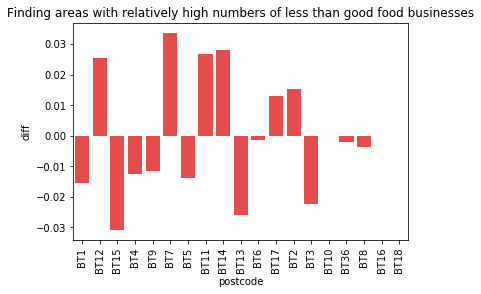

In [349]:
sns.barplot(df_full_vcount['postcode'], df_full_vcount['diff'], color='red',alpha=0.8)
plt.xticks(rotation=90)
plt.title('Finding areas with relatively high numbers of less than good food businesses')
plt.show()

So the following postcodes have a relatively high number of less than good food businesses:
<br>
1. BT7 = South Belfast: Ormeau, Botanic, University
2. BT14 = North Belfast: Crumlin Road, Ballysillan, Upper Ballysillan, Ardoyne
3. BT11 = West Belfast: Andersonstown, Lenadoon, Suffolk, Ladybrook, Turf Lodge
4. BT12 = South Belfast: Sandy Row, The Village
5. BT2 = Belfast City Centre (south of City Hall)
6. BT17 = West Belfast: Dunmurry, Hannahstown, Twinbrook, Poleglass, Lagmore

Finally in this section I want to see if there is any correlation between the hygiene, structural and confidenceInManagement scores

In [350]:
drop_cols = ['extractDate', 'localAuthorityBusinessID', 'businessName',
       'businessType', 'businessTypeID', 'addressLine1', 'addressLine2',
       'AddressLine3', 'adressLine4', 'postCode', 'ratingValue', 'ratingKey',
       'RatingDate', 'localAuthorityCode', 'localAuthorityName', 'newRatingPending', 'longitude',
       'latitude', 'postCode_1']
df_corr = df.drop(drop_cols,axis=1)
df_corr.head()

,hygiene,structural,confidenceInManagement
0,5.0,5.0,5.0
1,5.0,0.0,5.0
2,5.0,10.0,5.0
3,0.0,5.0,5.0
4,5.0,5.0,5.0


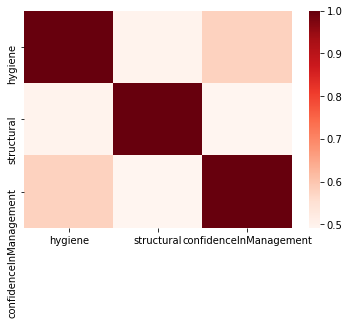

In [351]:
#calculate the Pearson correlation scores and plot as a heat map
ax = sns.heatmap(df_corr.corr(),cmap='Reds')

There appears to be some correlation between hygiene and confidence in management but it is weak and no other correlations seem to exist.

<a id='section4'></a>
**Section 4** - using Machine Learning to predict hygiene score

In [352]:
df.columns

Index(['extractDate', 'localAuthorityBusinessID', 'businessName',
       'businessType', 'businessTypeID', 'addressLine1', 'addressLine2',
       'AddressLine3', 'adressLine4', 'postCode', 'ratingValue', 'ratingKey',
       'RatingDate', 'localAuthorityCode', 'localAuthorityName', 'hygiene',
       'structural', 'confidenceInManagement', 'newRatingPending', 'longitude',
       'latitude', 'postCode_1'],
      dtype='object')

In [353]:
drop_cols = ['localAuthorityName','postCode','extractDate','businessName','businessType','addressLine1', 'addressLine2', 'AddressLine3','adressLine4', 'ratingKey','RatingDate', 'localAuthorityCode']
df = df.drop(drop_cols,axis=1)

In [354]:
df.head()

,localAuthorityBusinessID,businessTypeID,ratingValue,hygiene,structural,confidenceInManagement,newRatingPending,longitude,latitude,postCode_1
0,129370,1,5,5.0,5.0,5.0,False,-5.929560,54.594888,BT2
1,237805,5,5,5.0,0.0,5.0,False,-5.936459,54.613263,BT15
2,131208,1,4,5.0,10.0,5.0,False,-5.925803,54.601509,BT1
3,162058,7843,5,0.0,5.0,5.0,False,-5.926958,54.601627,BT1
4,238630,1,5,5.0,5.0,5.0,False,-5.898986,54.583713,BT6


In [355]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split

le.fit(df['newRatingPending'])
df['newRatingPending'] = le.transform(df['newRatingPending'])
df.head()

,localAuthorityBusinessID,businessTypeID,ratingValue,hygiene,structural,confidenceInManagement,newRatingPending,longitude,latitude,postCode_1
0,129370,1,5,5.0,5.0,5.0,0,-5.929560,54.594888,BT2
1,237805,5,5,5.0,0.0,5.0,0,-5.936459,54.613263,BT15
2,131208,1,4,5.0,10.0,5.0,0,-5.925803,54.601509,BT1
3,162058,7843,5,0.0,5.0,5.0,0,-5.926958,54.601627,BT1
4,238630,1,5,5.0,5.0,5.0,0,-5.898986,54.583713,BT6


In [356]:
missing_values_table(df)

Your selected dataframe has 10 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
longitude,118,4.3
latitude,118,4.3
postCode_1,102,3.7


In [357]:
print(df.shape)
df = df.dropna(axis=0,subset=['longitude','latitude','postCode_1'])
print(df.shape)

(2750, 10)
(2630, 10)


In [358]:
le = preprocessing.LabelEncoder()
le.fit(df['postCode_1'])
df['postCode_1'] = le.transform(df['postCode_1'])
df.head()

,localAuthorityBusinessID,businessTypeID,ratingValue,hygiene,structural,confidenceInManagement,newRatingPending,longitude,latitude,postCode_1
0,129370,1,5,5.0,5.0,5.0,0,-5.929560,54.594888,10
1,237805,5,5,5.0,0.0,5.0,0,-5.936459,54.613263,6
2,131208,1,4,5.0,10.0,5.0,0,-5.925803,54.601509,0
3,162058,7843,5,0.0,5.0,5.0,0,-5.926958,54.601627,0
4,238630,1,5,5.0,5.0,5.0,0,-5.898986,54.583713,15


In [359]:
le = preprocessing.LabelEncoder()
le.fit(df['hygiene'])
df['hygiene'] = le.transform(df['hygiene'])
df.head()

,localAuthorityBusinessID,businessTypeID,ratingValue,hygiene,structural,confidenceInManagement,newRatingPending,longitude,latitude,postCode_1
0,129370,1,5,1,5.0,5.0,0,-5.929560,54.594888,10
1,237805,5,5,1,0.0,5.0,0,-5.936459,54.613263,6
2,131208,1,4,1,10.0,5.0,0,-5.925803,54.601509,0
3,162058,7843,5,0,5.0,5.0,0,-5.926958,54.601627,0
4,238630,1,5,1,5.0,5.0,0,-5.898986,54.583713,15


In [360]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import tree

X = df.drop(['hygiene'], axis=1).values
y = df['hygiene'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

clf_rf = ske.RandomForestClassifier(n_estimators=150)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))
rank = clf_rf.feature_importances_
print(rank)

cols = df.drop(['hygiene'], axis=1).columns

0.743979721166033
[0.1708946  0.0740083  0.14280643 0.09631124 0.13676189 0.00180814
 0.15810722 0.15794469 0.06135749]


In [361]:
clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
clf_gb = clf_gb.fit(X_train, y_train)
print(clf_gb.score(X_test,y_test))
print(clf_gb.feature_importances_)

0.743979721166033
[0.12992032 0.05842255 0.25698257 0.0984067  0.13896554 0.00096997
 0.12773941 0.16773045 0.0208625 ]


In [362]:
clf_dt = tree.DecisionTreeClassifier(max_depth=4)
clf_dt = clf_dt.fit(X_train, y_train)
print(clf_dt.score(X_test,y_test))
print(clf_dt.feature_importances_)

0.7211660329531052
[0.         0.         0.42557923 0.13998796 0.39704662 0.
 0.01498845 0.02239774 0.        ]


**standardising/normalizing the input data**

In [363]:
from sklearn import preprocessing

# separate the data from the target attributes

standardized_X = preprocessing.scale(X)
normalized_X = preprocessing.normalize(X)

In [364]:
X_train, X_test, y_train, y_test = train_test_split(standardized_X,y,test_size=0.3, random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(normalized_X,y,test_size=0.3, random_state=0)

clf_rf = ske.RandomForestClassifier(n_estimators=500)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))
rank1 = clf_rf.feature_importances_
print(rank1)

0.7465145754119138
[0.1704587  0.07352961 0.14457897 0.09970939 0.13632147 0.00193946
 0.15457139 0.15867343 0.06021757]


standardizing the input produces a small improvement 0.7275 to 0.73 while normalizing reduces the accuracy to 0.69

increasing n_estimators to 500 improves accuracy to just over 74% (n_estimators is the number of trees in the forest)

In [365]:
cols1 = df.drop(['hygiene'], axis=1).columns
print(cols1)

Index(['localAuthorityBusinessID', 'businessTypeID', 'ratingValue',
       'structural', 'confidenceInManagement', 'newRatingPending', 'longitude',
       'latitude', 'postCode_1'],
      dtype='object')


In [366]:
def visualize_input_feature_importance(rank,cols):
    data = list(zip(rank, cols))
    df_import = pd.DataFrame(data, columns=['feature_importance', 'feature'])
    df_import.plot(kind='bar',x='feature',y='feature_importance',legend=False,title='relative importance of different input features');

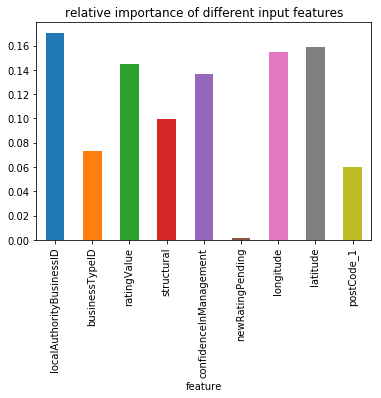

In [367]:
visualize_input_feature_importance(rank1,cols1) # input is normalised

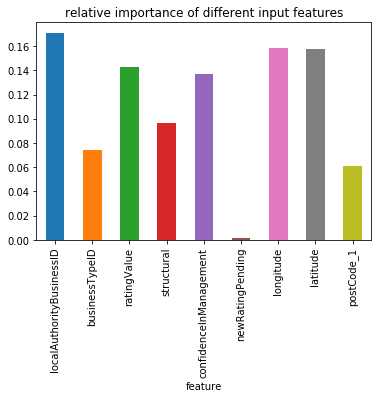

In [368]:
visualize_input_feature_importance(rank,cols) #input is not normalised

<a id='section5'></a>
In the above latitude and longitude are important or in other words hygiene is related to location.

# visualizing the geograpgical distribution of less than good businesses

In [369]:
print(df_lt_good.shape)
df_lt_good = df_lt_good.dropna(axis=0,subset=['longitude','latitude'])
print(df_lt_good.shape)

(338, 22)
(332, 22)


In [370]:
import matplotlib.pyplot as plt

#long = df['longitude'] these lists are for all businesses
#lat = df['latitude']

long = df_lt_good['longitude'] #this data is only for less than good hygiene businesses
lat = df_lt_good['latitude']


plt.hold(True)

plt.plot(long, lat, 'r.') 

import mplleaflet
#mplleaflet.show() # this will generate an html file
mplleaflet.display() ##plot showing locations of businesses with less than good hygiene scores